In [51]:
import keras
import cv2
import matplotlib.pyplot as plt
from skimage.transform import rotate, resize, SimilarityTransform, warp
import os
import itertools
import numpy as np
import random as rand
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.utils.training_utils import multi_gpu_model
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score
from sklearn.metrics import average_precision_score, confusion_matrix
from math import sqrt
from skimage.feature import blob_log
from skimage.color import rgb2gray
from matplotlib.patches import Circle
%matplotlib inline

In [20]:
MODEL_PATH = "./binary_classifier/net_2_model.h5"

THRESHOLD = 0.95

model = keras.models.load_model(MODEL_PATH)

In [24]:
# Build model

model2 = Sequential()
# First layer
model2.add(Convolution2D(8, (5, 5), activation='relu', padding='valid', input_shape=(None, None, 3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Second layer
model2.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Third layer
model2.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth layer
model2.add(Convolution2D(10, (3, 3), activation='relu', padding='valid'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Convolution2D(2, (4, 4), activation='softmax', padding='valid'))

model2.layers[0].set_weights(model.layers[0].get_weights())
model2.layers[2].set_weights(model.layers[2].get_weights())
model2.layers[4].set_weights(model.layers[4].get_weights())
model2.layers[6].set_weights(model.layers[6].get_weights())
first = model.layers[9].get_weights()[0].reshape(4, 4, 10, 2)
second = model.layers[9].get_weights()[1]
model2.layers[8].set_weights([first, second])

In [25]:
image = cv2.imread("./kaggle_sea_lions/Train/905.jpg")
image = image[1000:2000, 1000:2000]

pred = model2.predict((image.reshape(1, image.shape[0], image.shape[1], image.shape[2]))/255)
heatmap = pred[0, :, :, 0]
heatmap = cv2.resize(heatmap, dsize=(image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)

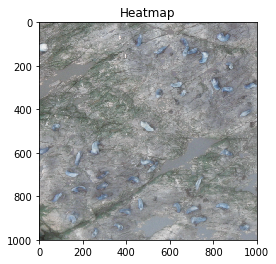

In [26]:
plt.imshow(image)
plt.title("Heatmap")
plt.show()

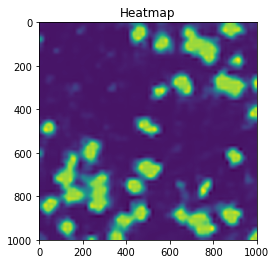

In [27]:
plt.imshow(heatmap)
plt.title("Heatmap")
plt.show()

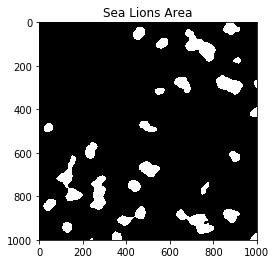

In [50]:
plt.imshow(heatmap > 0.9, cmap="gray")
plt.title("Sea Lions Area")
plt.show()

In [33]:
gray_heatmap = rgb2gray(heatmap > THRESHOLD)

blobs_log = blob_log(gray_heatmap, max_sigma=30, num_sigma=10, threshold=.1) # check parameters
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

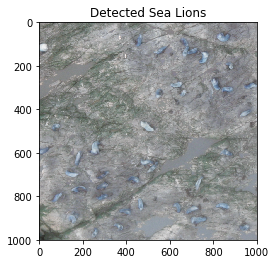

In [56]:
plt.imshow(image)
plt.title("Detected Sea Lions")
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
plt.show()